In [1]:
!pip install pmdarima
from statsmodels.tsa.stattools import adfuller
import pandas as pd
data = pd.read_csv(r"/kaggle/input/daily-climate-time-series-data/DailyDelhiClimateTest.csv").dropna()

data["date"]=pd.to_datetime(data["date"])
data.set_index("date",inplace=True)
print(data.shape)
data.tail(10)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 29.0 MB/s eta 0:00:0000:0100:01
(114, 4)


,meantemp,humidity,wind_speed,meanpressure
date,,,,
2017-04-15,31.222222,30.444444,5.966667,1002.444444
2017-04-16,31.000000,34.250000,2.100000,1003.250000
2017-04-17,32.555556,38.444444,5.366667,1004.444444
2017-04-18,34.000000,27.333333,7.811111,1003.111111
2017-04-19,33.500000,24.125000,9.025000,1000.875000
2017-04-20,34.500000,27.500000,5.562500,998.625000
2017-04-21,34.250000,39.375000,6.962500,999.875000
2017-04-22,32.900000,40.900000,8.890000,1001.600000
2017-04-23,32.875000,27.500000,9.962500,1002.125000


In [12]:
import numpy as np
data_hum = data[["humidity"]].copy()
data_hum["humidity-log"] = np.log(data_hum["humidity"])  # Log transformation
data_hum["humidity-diff"] = data_hum["humidity"].diff()  # First differencing
data_hum["log-diff-hum"] = data_hum["humidity-log"].diff()  # Differencing after log
data_hum.head(10)

,humidity,humidity-log,humidity-diff,log-diff-hum
date,,,,
2017-01-01,85.869565,4.452829,NaN,NaN
2017-01-02,77.222222,4.346687,-8.647343,-0.106142
2017-01-03,81.888889,4.405363,4.666667,0.058676
2017-01-04,70.050000,4.249209,-11.838889,-0.156154
2017-01-05,74.944444,4.316747,4.894444,0.067538
2017-01-06,79.318182,4.373467,4.373737,0.056720
2017-01-07,95.833333,4.562611,16.515152,0.189143
2017-01-08,83.526316,4.425162,-12.307018,-0.137449
2017-01-09,80.809524,4.392095,-2.716792,-0.033067


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='date', ylabel='humidity'>

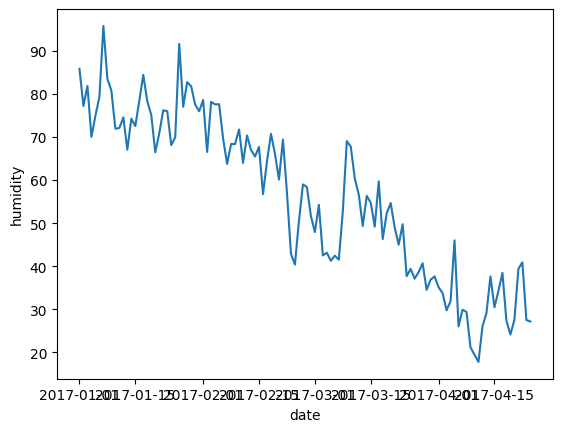

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.lineplot(x=data.index, y = "humidity",data=data)

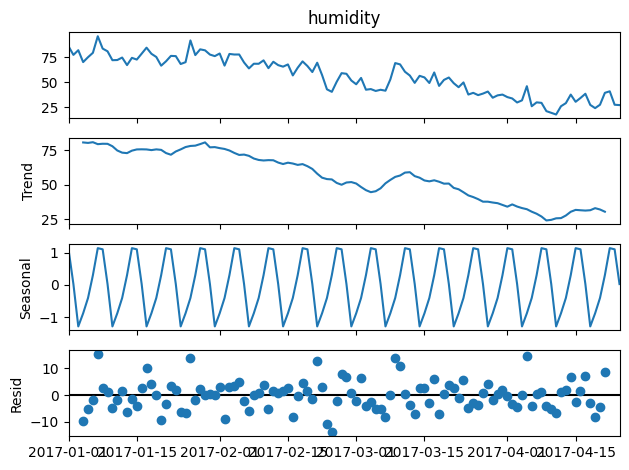

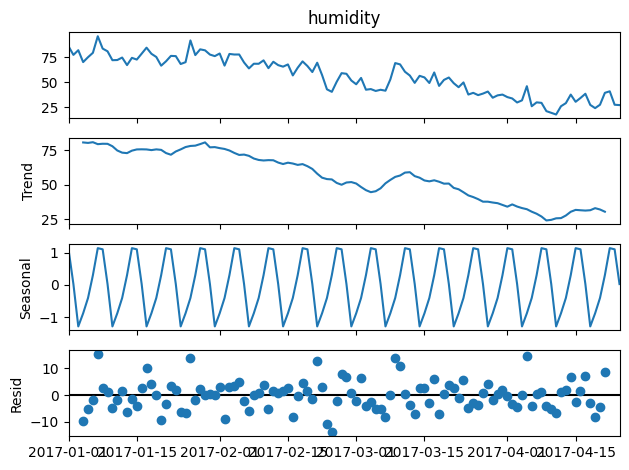

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose
resl = seasonal_decompose(data["humidity"])
resl.plot()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='date', ylabel='wind_speed'>

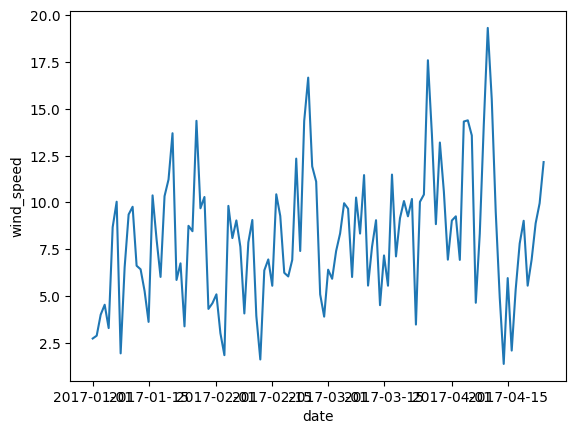

In [5]:
sns.lineplot(x=data.index, y = "wind_speed",data=data)

In [10]:
df_series_hum = data_hum["log-diff-hum"].dropna()
def tester(data):
    result = adfuller(data)
    series_adf = pd.Series(data=result[0:4],index=["Test-Statistics","p-value","No-of-lags-Used","No-of-Observation-Used"])
    criticality = {}
    for key,val in result[4].items():
        criticality[f"{key}-criticality"] = val
    return series_adf, criticality
series_adf, criticality = tester(df_series_hum)
print(series_adf, criticality)

Test-Statistics          -6.800290e+00
p-value                   2.246089e-09
No-of-lags-Used           6.000000e+00
No-of-Observation-Used    1.060000e+02
dtype: float64 {'1%-criticality': -3.4936021509366793, '5%-criticality': -2.8892174239808703, '10%-criticality': -2.58153320754717}


In [50]:
from statsmodels.tsa.holtwinters import Holt, ExponentialSmoothing

def train_test_splitter(dataframe, col_name:str):
    train_data = dataframe[col_name].iloc[0:round(len(data)*0.07)]
    test_data = dataframe[col_name].iloc[round(len(data)*0.07):]
    test_size = len(test_data)
    return train_data, test_data, test_size

train_data, test_data, test_size = train_test_splitter(data,"humidity")
holt_model = Holt(train_data)
holt_fitter = holt_model.fit(smoothing_level=0.8, smoothing_slope=0.2, optimized=False)  

forecast_holt = holt_fitter.forecast(steps=test_size)

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(test_data, forecast_holt)
mse = mean_squared_error(test_data, forecast_holt)
rmse = np.sqrt(mse)
print(f"MAE: {mae}, RMSE: {rmse}, MSE: {mse}")
forecast_holt, test_data

MAE: 7.298612154921348, RMSE: 8.956965743888947, MSE: 80.22723533720009


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/tmp/ipykernel_30/1366379673.py:11: FutureWarning: the 'smoothing_slope' keyword is deprecated, use 'smoothing_trend' instead.
  holt_fitter = holt_model.fit(smoothing_level=0.8, smoothing_slope=0.2, optimized=False)


(2017-01-09    84.647466
 2017-01-10    84.005595
 2017-01-11    83.363724
 2017-01-12    82.721853
 2017-01-13    82.079982
                 ...    
 2017-04-20    19.818479
 2017-04-21    19.176608
 2017-04-22    18.534736
 2017-04-23    17.892865
 2017-04-24    17.250994
 Freq: D, Length: 106, dtype: float64,
 date
 2017-01-09    80.809524
 2017-01-10    71.944444
 2017-01-11    72.111111
 2017-01-12    74.578947
 2017-01-13    67.058824
                 ...    
 2017-04-20    27.500000
 2017-04-21    39.375000
 2017-04-22    40.900000
 2017-04-23    27.500000
 2017-04-24    27.142857
 Name: humidity, Length: 106, dtype: float64)

In [36]:
model_holt_winters = ExponentialSmoothing(train_data, trend="add",seasonal_periods=4,seasonal="add")
fit = model_holt_winters.fit(smoothing_level=0.8, smoothing_slope=0.2, optimized=True)
forecast_winters = fit.forecast(steps=test_size)
forecast_winters

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/tmp/ipykernel_30/3099560280.py:2: FutureWarning: the 'smoothing_slope' keyword is deprecated, use 'smoothing_trend' instead.
  fit = model_holt_winters.fit(smoothing_level=0.8, smoothing_slope=0.2, optimized=True)


2017-01-09     90.492539
2017-01-10     89.410822
2017-01-11    100.826034
2017-01-12     89.346603
2017-01-13     96.510627
                 ...    
2017-04-20    239.863026
2017-04-21    251.278237
2017-04-22    239.798807
2017-04-23    246.962831
2017-04-24    245.881114
Freq: D, Length: 106, dtype: float64

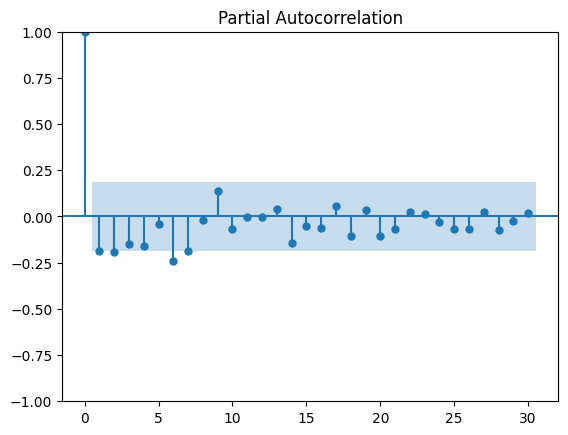

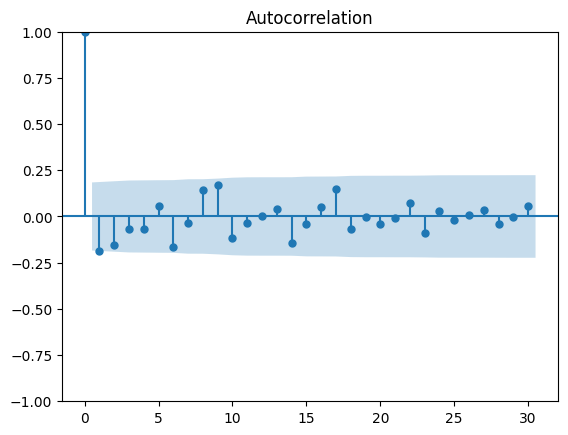

In [16]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_pacf(data_hum["log-diff-hum"].dropna(),lags=30)
plot_acf(data_hum["log-diff-hum"].dropna(),lags=30)
plt.show()

In [47]:
from pmdarima import auto_arima
model_auto = auto_arima(data["humidity"],start_p = 0, start_q =0, max_p = 7, max_q = 7,seasonal= True, stepwise=True, trace=True)
from statsmodels.tsa.arima.model import ARIMA
train_data_log, test_data_log, test_size_log = train_test_splitter(data_hum,"humidity")
model_arima = ARIMA(train_data_log.dropna(), order=model_auto.order)
model_fit_arima = model_arima.fit()
print(model_fit_arima.summary())
auto_arima_forecast = model_fit_arima.forecast(steps=test_size)
err = mean_absolute_error(test_data,auto_arima_forecast)
err

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=777.729, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=772.806, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=767.723, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=776.282, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=761.190, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=760.866, Time=0.14 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=764.383, Time=0.07 sec

Best model:  ARIMA(0,1,3)(0,0,0)[0] intercept
Total fit time: 1.864 seconds
                               SARIMAX Results                                
Dep. Variable:               humidity   N

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


27.358476630144168

In [48]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
sarimax = SARIMAX(train_data_log.dropna(), order=model_auto.order, seasonal_order=model_auto.seasonal_order)
model_fit_sarimax = model.fit()
print(model_fit_sarimax.summary())
forecast_SARIMA = model_fit.forecast(steps=test_size_log)
last_log_value = data_hum["humidity-log"].iloc[-1]

cumulative_sum = np.cumsum(forecast_SARIMA) + last_log_value
original_scale_forecast_sarima = np.exp(cumulative_sum)
print(original_scale_forecast_sarima, test_data)

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


                               SARIMAX Results                                
Dep. Variable:           log-diff-hum   No. Observations:                    7
Model:                 ARIMA(6, 1, 6)   Log Likelihood                   7.587
Date:                Sun, 01 Dec 2024   AIC                             10.825
Time:                        11:52:26   BIC                              8.118
Sample:                    01-02-2017   HQIC                            -0.012
                         - 01-08-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5010      0.007    208.205      0.000       1.487       1.515
ar.L2         -1.0617      0.003   -391.367      0.000      -1.067      -1.056
ar.L3         -0.0516      0.006     -9.156      0.0

/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
